In [1]:
# import libraries needed for data cleaning and visualization
import numpy as np
import pandas as pd
from scipy import stats
from matplotlib import pyplot as plt
import seaborn as sns

In [3]:
# ------------ IMPORT DATA --------------

# load entire dataset as a pandas dataframe
entire_df = pd.read_csv('/Users/frithsen/Documents/Toy_Data_code/ML_data_doubled.csv', nrows=170)

# Check Data Types
entire_df.dtypes
entire_df['MMSE']=pd.to_numeric(entire_df['MMSE'], errors='coerce')  # change MMSE from object to float so math can be done on it  

# Describe data
entire_df.describe()

,Sub#,PASE,MMSE,BDI,RAVLT_Total,RAVLT_Delay,LMS_Delay,Trails_A,Trails_B,Digit_Span_Total,WAIS_IQ,MS_LDI,ANTS_Avg_Thickness,FS_avg_thickness,Education,Age,Group
count,170.000000,170.000000,163.000000,163.000000,170.000000,170.000000,161.000000,162.000000,162.000000,162.000000,170.000000,157.00000,146.000000,146.000000,169.000000,170.000000,170.000000
mean,122339.600000,94.804118,29.000000,2.668712,52.858824,10.976471,30.409938,24.962963,61.697531,17.771605,116.188235,0.22465,39.881918,2.437684,16.390533,54.723529,0.500000
std,768.521938,40.329581,1.094318,4.112695,8.961658,2.973160,7.032489,8.591408,23.513730,3.594811,9.747698,0.20339,4.328501,0.317580,2.490727,18.798213,0.501477
min,120236.000000,21.000000,26.000000,0.000000,28.000000,2.000000,12.000000,11.000000,24.000000,8.000000,85.000000,-0.41000,33.060000,1.474060,12.000000,20.000000,0.000000
25%,121687.250000,66.972500,28.000000,0.000000,47.000000,9.000000,25.000000,19.000000,45.000000,15.250000,110.000000,0.08000,37.012500,2.441606,15.000000,37.500000,0.000000
50%,122397.500000,89.405000,29.000000,1.000000,53.000000,11.000000,31.000000,23.000000,58.500000,17.000000,117.000000,0.22000,39.025000,2.521125,16.000000,59.000000,0.500000
75%,122769.750000,115.510000,30.000000,4.000000,59.000000,13.750000,35.000000,28.750000,74.000000,20.000000,123.750000,0.34000,42.100000,2.620915,18.000000,71.000000,1.000000
max,123976.000000,260.730000,30.000000,23.000000,71.000000,15.000000,44.000000,58.000000,195.000000,29.000000,135.000000,0.81000,62.000000,2.787745,26.000000,87.000000,1.000000


In [4]:
# ------------ CLEAN DATA ----------------

# Remove Unnecessary variable(s)
entire_df = entire_df.drop(['Sub#'], axis=1) # this variable is randomly assigned and not predictive of group
                            
# Deal with Categorical variables (i.e., Race and ApoE)

# Show how many of each Race we have                            
entire_df["Race"].value_counts()  

# Replace Black, Pac Islander, Am Indian, AmIn races with 'Rare' 
entire_df["Race"] = entire_df["Race"].replace(['Pac Islander', 'Am Indian', 'AmIn'], 'Rare')

# Next, dummy code the modified Race variable
dummies_df = pd.get_dummies(entire_df,columns=['Race'])                        
                            
# Convert gene info into binary variable (if it has a 3 in it then they are a carrier for the gene)
dummies_df['ApoE'] = dummies_df['ApoE'].str.contains('4').astype(float) 

ApoE                  14.117647
FS_avg_thickness      14.117647
ANTS_Avg_Thickness    14.117647
MS_LDI                 7.647059
LMS_Delay              5.294118
Digit_Span_Total       4.705882
Trails_B               4.705882
Trails_A               4.705882
MMSE                   4.117647
BDI                    4.117647
Education              0.588235
PASE                   0.000000
RAVLT_Total            0.000000
RAVLT_Delay            0.000000
Race_White             0.000000
Race_Rare              0.000000
Age                    0.000000
Group                  0.000000
Race_Asian             0.000000
Race_Black             0.000000
WAIS_IQ                0.000000
dtype: float64


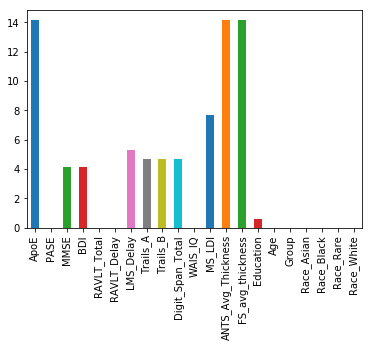

In [5]:
# Missing Data Detection

# this function will compute the percent of missing values for each feature and will then produce a bar plot to visualize this
def check_for_missing_data():
    num_nan = dummies_df.isnull().sum()
    percent_nan_df = (num_nan/(len(entire_df))) * 100
    print(percent_nan_df.sort_values(ascending=False))
    percent_nan_df.plot(kind='bar')

check_for_missing_data()    

In [6]:
# Estimate Missing Values

# this function will first get the indices of missing variables. it will then try to get an estimate of the missing value by looking at subjects with the same age and education level 
# and taking the median of those values. If there are no similar subjects in terms of age and education, the median of all subjects will be used.
dummies_df_copy = dummies_df.copy()

def fill_missing_values(variable):

    index_NaN =  list(dummies_df[variable][dummies_df[variable].isnull()].index)

    for i in index_NaN :
        median_val = dummies_df[variable].median()
        predicted_val = dummies_df[variable][(dummies_df['Age'] == dummies_df.iloc[i]["Age"]) & (dummies_df['Education'] == dummies_df.iloc[i]["Education"])].median()
        if not np.isnan(predicted_val) :
            dummies_df_copy[variable].iloc[i] = predicted_val
        else :
            dummies_df_copy[variable].iloc[i] = median_val
            
    return dummies_df_copy    

In [7]:
# select all variables we want to fill in missing values for and loop through each of these

vars = ['ANTS_Avg_Thickness', 'MS_LDI', 'MMSE', 'BDI', 'LMS_Delay', 'Trails_A', 'Trails_B', 'Digit_Span_Total', 'FS_avg_thickness']

for var in vars:
    dummies_df = fill_missing_values(var)

/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:189: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


ApoE                  14.117647
Education              0.588235
Digit_Span_Total       0.000000
PASE                   0.000000
MMSE                   0.000000
BDI                    0.000000
RAVLT_Total            0.000000
RAVLT_Delay            0.000000
LMS_Delay              0.000000
Trails_A               0.000000
Trails_B               0.000000
Race_White             0.000000
Race_Rare              0.000000
MS_LDI                 0.000000
ANTS_Avg_Thickness     0.000000
FS_avg_thickness       0.000000
Age                    0.000000
Group                  0.000000
Race_Asian             0.000000
Race_Black             0.000000
WAIS_IQ                0.000000
dtype: float64


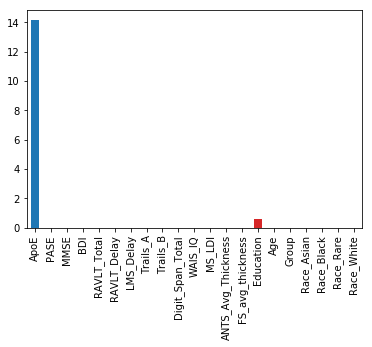

In [8]:
# check again for missing values
check_for_missing_data()   

In [9]:
# we still have missing values for ApoE and Education

# Replace the 1 missing education value with the median education value
med = dummies_df['Education'].median()
dummies_df['Education'] = dummies_df['Education'].fillna(value=med)

In [10]:
# check to see the value counts of the ApoE variable
dummies_df["ApoE"].value_counts()

0.0    112
1.0     34
Name: ApoE, dtype: int64

In [11]:
## Replace missing ApoE with 1
dummies_df['ApoE'] = dummies_df['ApoE'].fillna(value=1)

Race_White            0.0
Digit_Span_Total      0.0
PASE                  0.0
MMSE                  0.0
BDI                   0.0
RAVLT_Total           0.0
RAVLT_Delay           0.0
LMS_Delay             0.0
Trails_A              0.0
Trails_B              0.0
WAIS_IQ               0.0
Race_Rare             0.0
MS_LDI                0.0
ANTS_Avg_Thickness    0.0
FS_avg_thickness      0.0
Education             0.0
Age                   0.0
Group                 0.0
Race_Asian            0.0
Race_Black            0.0
ApoE                  0.0
dtype: float64


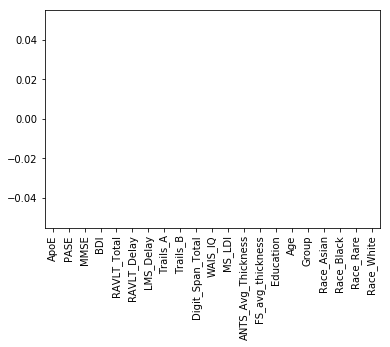

In [12]:
# check again for missing data
check_for_missing_data()

In [13]:
# Check for outliers
# this function will define outliers as values that are more than 3 zscores for that particular column

def check_for_outliers(variable):
    data_df = dummies_df[variable]
    outliers = data_df[(np.abs(stats.zscore(data_df))>3)]
    
    return outliers

In [14]:
# loop through each column and check for outliers
outliers = []
for var in vars:
    this_outliers = check_for_outliers(var)
    print(this_outliers)
    outliers.append(this_outliers)

116    62.00
157    58.16
Name: ANTS_Avg_Thickness, dtype: float64
78   -0.41
Name: MS_LDI, dtype: float64
Series([], Name: MMSE, dtype: float64)
32    21.0
57    23.0
78    19.0
Name: BDI, dtype: float64
Series([], Name: LMS_Delay, dtype: float64)
94     58.0
97     51.0
157    54.0
164    53.0
Name: Trails_A, dtype: float64
157    195.0
Name: Trails_B, dtype: float64
151    29.0
Name: Digit_Span_Total, dtype: float64
104    1.541960
105    1.540245
113    1.551305
134    1.544020
150    1.532650
157    1.474060
160    1.518420
Name: FS_avg_thickness, dtype: float64


/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2963: UserWarning: To output multiple subplots, the figure containing the passed axes is being cleared
  exec(code_obj, self.user_global_ns, self.user_ns)


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x118b59cc0>,
      dtype=object)

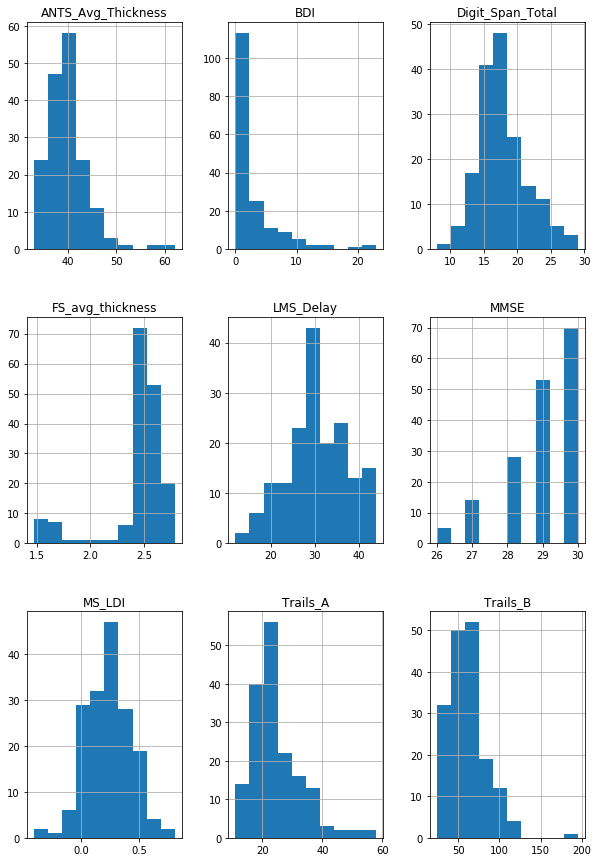

In [15]:
# plot a histogram of variables with outliers
fig, axes = plt.subplots(3, 3, figsize=(10, 15))
ax = fig.gca()
dummies_df.hist(column=vars,ax=ax)

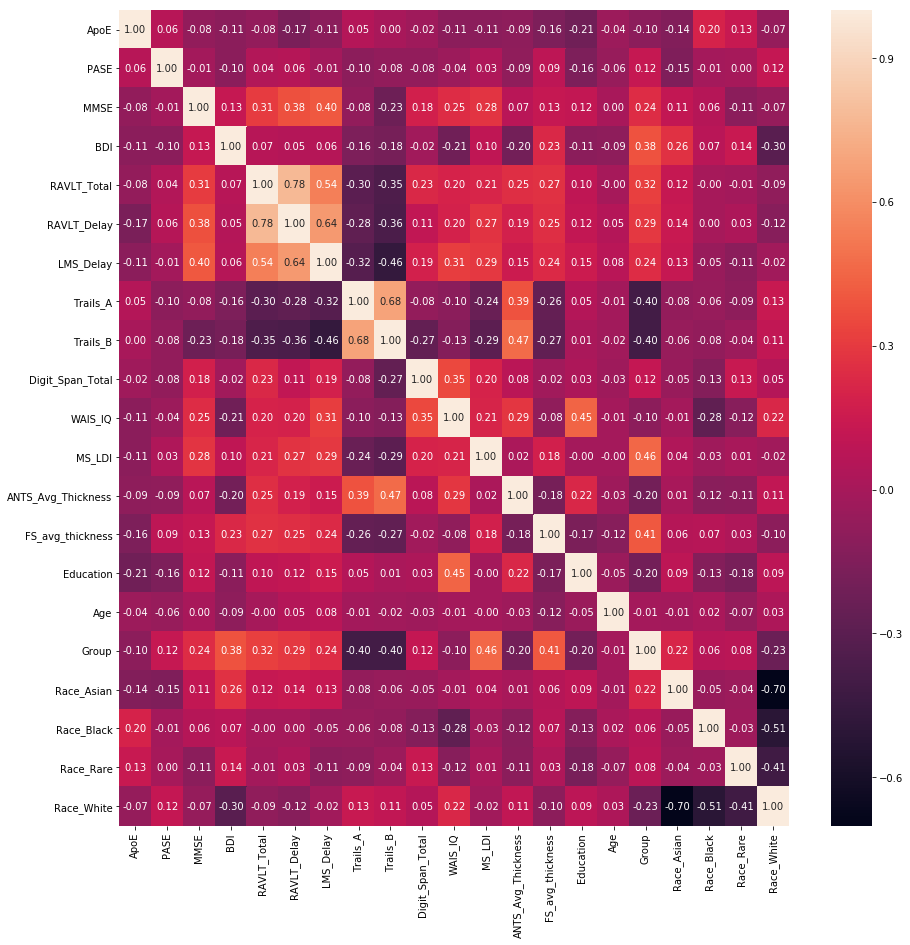

In [16]:
# plot correlation matrix of predictor variables
corr_matrix = dummies_df.corr()
fig, ax = plt.subplots(figsize= (15,15))
sns.heatmap(corr_matrix, annot=True, fmt=".2f")

In [ ]:
# looks like Trails A is highly correlated with Trails B
# and also that RAVLT Total is highly correlated with RAVLT Delay
# Let's drop one of each pair
dummies_df = dummies_df.drop(['RAVLT_Delay'], axis=1)
dummies_df = dummies_df.drop(['Trails_B'], axis=1)
dummies_df = dummies_df.drop(['LMS_Delay'], axis=1)

In [21]:
# -------------- TRAIN DATA ------------------- #
# import libraries you will need to data training
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.linear_model import LogisticRegression

In [22]:
num_tests = 1

# create arrays filled with zeros that will be filled
accuracy_values = np.zeros(num_tests)
precision_values = np.zeros(num_tests)
recall_values = np.zeros(num_tests)
coef_values = np.zeros([num_tests,17])
intercept_values = np.zeros(num_tests)
auc_roc_values = np.zeros(num_tests)
y_pred_proba_pos_values = np.zeros([34,num_tests])

In [23]:
for i in range(num_tests):

    # Create X (features) and y (response) variables
    X_full = dummies_df.drop(['Group'],axis=1)
    y_full = dummies_df['Group']

    # create validation (hold-out set)
    X, X_test, y, y_test = train_test_split(X_full, y_full, stratify=y_full,test_size=0.2, random_state=4)


    # Normalize the features and apply transform to test set
    from sklearn.preprocessing import StandardScaler
    names = X.columns.values
    sc = StandardScaler().fit(X)
    X_norm = sc.transform(X)
    X_norm_df = pd.DataFrame(X_norm, columns=[(names)])
    X_test_norm = sc.transform(X_test)

    # create cross validation method
    rskf = RepeatedStratifiedKFold(n_splits=10, n_repeats=5)

    # use GridSearch to find best value of C
    from sklearn.model_selection import GridSearchCV
    param_grid = {'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000] }
    clf = GridSearchCV(LogisticRegression(penalty='l1'), param_grid,cv=rskf)
    clf.fit(X_norm,y)
    
    
    print("Best estimator {}".format(clf.best_estimator_))
    print("Best training accuracy{0:.3f}".format(clf.best_score_))

    # get results
    results = clf.cv_results_
    coefs = clf.best_estimator_.coef_
    intercepts = clf.best_estimator_.intercept_
    

    # predict values from test set
    y_pred = clf.predict(X_test_norm)
    y_pred_proba = clf.predict_proba(X_test_norm)
    y_pred_proba_pos = y_pred_proba[:,1]
    y_pred_log_proba = clf.predict_log_proba(X_test_norm)
    
    # check accuracy of prediction
    from sklearn import metrics
    
    accuracy = metrics.accuracy_score(y_test,y_pred)
    precision = metrics.precision_score(y_test,y_pred)
    recall = metrics.recall_score(y_test,y_pred)
    auc_roc = metrics.roc_auc_score(y_test,y_pred)
    
    print("Test set accuracy score for best params{0:.3f}".format(accuracy))
    print("Test set precision score for best params{0:.3f}".format(precision))
    print("Test set recall score for best params{0:.3f}".format(recall))
    
    accuracy_values[i] = accuracy
    precision_values[i] = precision
    recall_values[i] = recall
    coef_values[i,:] = coefs
    intercept_values[i] = intercepts
    auc_roc_values[i] = auc_roc
    y_pred_proba_pos_values[:,i] = y_pred_proba_pos

Best estimator LogisticRegression(C=0.1, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l1', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)
Best training accuracy0.804
Test set accuracy score for best params0.853
Test set precision score for best params0.833
Test set recall score for best params0.882


In [24]:
# get average from the various rounds
accuracy_mean = accuracy_values.mean()
precision_mean = precision_values.mean()
recall_mean = recall_values.mean()
coef_values_mean = coef_values.mean(axis=0)
intercept_mean = intercept_values.mean()
auc_roc_mean = auc_roc_values.mean()
y_pred_proba_pos_mean = y_pred_proba_pos_values.mean(axis=1)

# get std dev from the various rounds
accuracy_sd = accuracy_values.std()
precision_sd = precision_values.std()
recall_sd = recall_values.std()
coef_values_sd = coef_values.std(axis=0)
intercept_sd = intercept_values.std()
auc_roc_sd = auc_roc_values.std()
y_pred_proba_pos_sd = y_pred_proba_pos_values.std(axis=1)

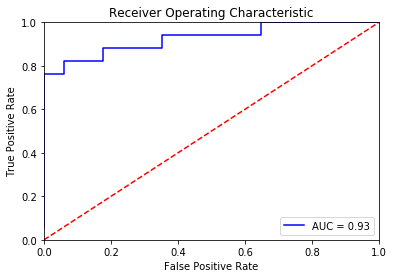

In [25]:
# ---- MAKE SOME PLOTS TO VISUALIZE RESULTS ------  

# plot the average ROC Curve
fpr,tpr,threshold = metrics.roc_curve(y_test,y_pred_proba_pos) 
roc_auc = metrics.auc(fpr,tpr)       
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()    

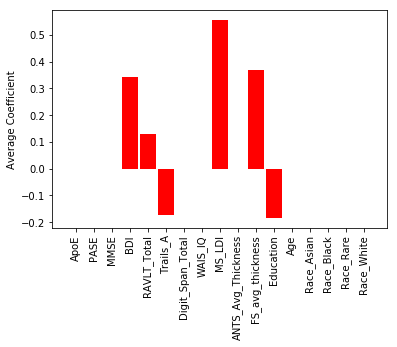

In [26]:
# plot average coefficients
features = X_full.columns.values
n_groups = 17
ind = np.arange(1,n_groups+1)
width = .9

fig, ax = plt.subplots()
ax.bar(ind,coef_values_mean,width,color='r')
ax.set_ylabel('Average Coefficient')
ax.set_xticks(ind)
ax.set_xticklabels(features,rotation = 90)
plt.show()

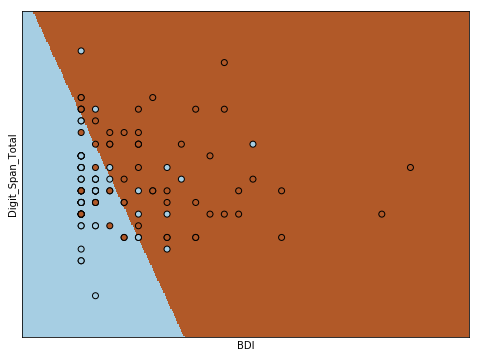

In [27]:
# plot decision boundary

h = .02  # step size in the mesh
#X = X_norm[:,10:12]
X = X_norm_df[['BDI', 'Digit_Span_Total']]
clf.fit(X,y)

x_min, x_max = X.iloc[:, 0].min() - 1, X.iloc[:, 0].max() + 1
y_min, y_max = X.iloc[:, 1].min() - 1, X.iloc[:, 1].max() + 1

xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])

# Put the result into a color plot
Z = Z.reshape(xx.shape)
plt.figure(1, figsize=(8, 6))
plt.pcolormesh(xx, yy, Z, cmap=plt.cm.Paired)

# Plot also the training points
plt.scatter(X.iloc[:, 0], X.iloc[:, 1], c=y, edgecolors='k', cmap=plt.cm.Paired)
plt.xlabel('BDI')
plt.ylabel('Digit_Span_Total')

plt.xlim(xx.min(), xx.max())
plt.ylim(yy.min(), yy.max())
plt.xticks(())
plt.yticks(())

plt.show()

In [ ]:
# ---------- RUN PERMUTATION TO TEST FOR SIGNIFICANCE ---------------

# run permutation to test significance
from sklearn.model_selection import permutation_test_score
score, permutation_scores, pvalue = permutation_test_score(clf, X_norm, y, scoring="accuracy", cv=rskf, n_permutations=5)

print("Classification score %s (pvalue : %s)" % (score, pvalue))

In [ ]:
# plot histogram of permutations test results

n_classes=2
plt.hist(permutation_scores, 20, label='Permutation scores',edgecolor='black')
ylim = plt.ylim()
plt.plot(2 * [score], ylim, '--r', linewidth=3,label='Classification Score:'' (pvalue= %.3f)' % pvalue)
plt.plot(2 * [1. / n_classes], ylim, '--k', linewidth=3, label='Luck')

plt.ylim(ylim)
plt.legend(bbox_to_anchor=(0.8,-.2))
plt.xlabel('Score')
plt.show()